In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class Bandit:
    def __init__(self, mu, mu_upper_limit=None):
        self.mu = mu
        # if mu_upper_limit is None, this will be an Epsilon-Greedy or UCB bandit.
        # Else, it would be an optimistic-initial value bandit
        self.mean = mu_upper_limit if mu_upper_limit else 0.0
        self.N = 1 if mu_upper_limit else 0
        
    def pull(self):
        return np.random.randn() + self.mu
    
    def update(self, x):
        self.N += 1
        aN = 1.0/self.N
        self.mean = (1.0 - aN)*self.mean + aN*x
    
    def get_mean(self):
        return self.mean

In [8]:
def run_experiment(m1, m2, eps=None, mu_upper_limit=None, which_method='epsilon', N_iter=10000):
    def _epsilon_greedy():
        bandits = [Bandit(m1), Bandit(m2)]
        data = np.empty(N_iter)
        for i in range(N_iter):
            p_ = np.random.random()
            if p_ < eps: # Explore an arm (randomly)
                which_bandit = np.random.choice(len(bandits))
            else: # Explot best arm using their mean value
                which_bandit = np.argmax([b.get_mean() for b in bandits])
            x = bandits[which_bandit].pull()
            bandits[which_bandit].update(x)
            data[i] = x
            
        return data
    
    def _optimistic_initial_value():
        if not mu_upper_limit:
            raise ValueError("mu_upper_limit cannot be None. Provide an upper limit for sampling mean.")
        bandits = [Bandit(m1, mu_upper_limit), Bandit(m2, mu_upper_limit)]
        data = np.empty(N_iter)
        for i in range(N_iter):
            which_bandit = np.argmax([b.get_mean() for b in bandits])
            # Sample a new data from the arm found above
            x = bandits[which_bandit].pull()
            bandits[which_bandit].update(x)
            data[i] = x
            
        return data
    
    def _UCB1():
        # Chernoff-Hoeffding Bound
        # Exponentially decreasing bounds on tail distributions of sums of independent variables
        # https://en.wikipedia.org/wiki/Chernoff_bound. 
        def __compute_UCB(mean, n_total, n_arm):
            # to avoid division by zero
            pert = 1e-16
            return mean + np.sqrt(2.0*np.log(n_total)/(n_arm + pert))

        bandits = [Bandit(m1), Bandit(m2)]
        data = np.empty(N_iter)
        for i in range(N_iter):
            # compute upper confidence bound according to Cernoff-Hoeffding formula
            ucbs = [__compute_UCB(b.get_mean(), i+1, b.N) for b in bandits]
            which_bandit = np.argmax(ucbs)
            # Sample a new data from the arm found above
            x = bandits[which_bandit].pull()
            bandits[which_bandit].update(x)
            data[i] = x
        return data
    
    def __cumulative_avg(data):
        return np.cumsum(data) / (np.arange(len(data))+1)
    
    if which_method == 'epsilon':
        data = _epsilon_greedy()
    elif which_method == 'UCB1':
        data = _UCB1()
    elif which_method == 'optimistic':
        data = _optimistic_initial_value()
    else:
        print("Warning. No method provided. Switching to Epsilon-greedy algorithm. Use 'epsilon', 'UCB1', 'optimistic'.")
        data = _epsilon_greedy()

    return __cumulative_avg(data)

In [16]:
# np.random.seed(1001)

In [47]:
m1 = 0.4
m2 = 0.6
N_iter = 10000

In [48]:
eps = 0.1
exp1 = run_experiment(m1=m1, m2=m2, eps=eps, N_iter=N_iter, which_method='epsilon')

In [49]:
mu_upper_limit = 100
exp2 = run_experiment(m1=m1, m2=m2, N_iter=N_iter, mu_upper_limit=mu_upper_limit, which_method='optimistic')

In [50]:
exp3 = run_experiment(m1=m1, m2=m2, N_iter=N_iter, which_method='UCB1')

In [51]:
print(exp3[-1])

0.5991850844549969


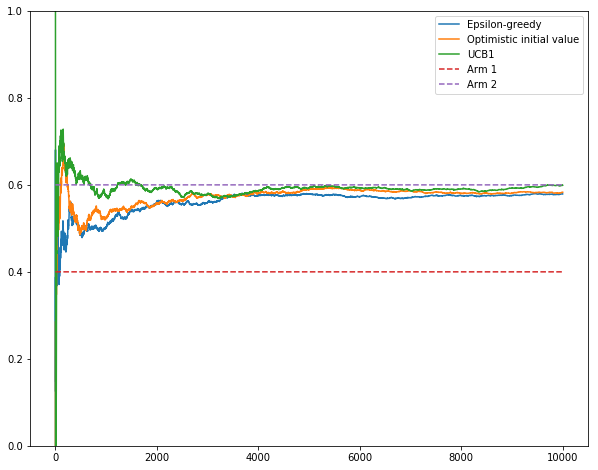

In [52]:
plt.figure(figsize=(10,8))
plt.plot(exp1, label='Epsilon-greedy')
plt.plot(exp2, label='Optimistic initial value')
plt.plot(exp3, label='UCB1')
plt.plot(np.ones(len(exp1))*m1, label='Arm 1', linestyle='dashed')
plt.plot(np.ones(len(exp1))*m2, label='Arm 2', linestyle='dashed')
plt.ylim([0,1])
plt.legend()
plt.show()